# Satellite Intelligence for Catastrophic Natural Disaster Recovery: Assessing Damage and First Responder Priorities through Geospatial Imagery
## Main (Execution of other notebooks, making predictions, model performance, and results)

The Main.ipynb notebook orchestrates the execution of other notebooks, including DataPreparation.ipynb, DataExploration.ipynb, and Modeling.ipynb. It handles function calls to these notebooks, loads all models, makes predictions to evaluate model performance, and compares results and summary findings. The models are not uploaded to GitHub due to their large file size.

**Group 4:** Jeremiah Fa'atiliga, Ravita Kartawinata, Sowmiya Kanmani Maruthavanan

## Table of Contents
1. [Importing Libraries](#importing-libraries)
2. [Running notebooks and loading the data](#running-notebooks-data-loading)
    1. [Running Data Preparation and Modeling notebooks](#running-data-preparation-and-modeling-notebooks)
    2. [Loading the images and JSON data](#loading-images-and-JSON-data)
    3. [Running Data Exploration notebook](#running-data-exploration-notebook)
3. [Data Preprocessing](#data-preprocessing)
4. [Data Preparation for Damage Classification](#data-preparation-for-damage-classification)
    1. [Class Imbalance](#class-imbalance)
    2. [Preparing data for stage 1 ResNet-50 model training](#preparing-data-for-stage1-resnet50-model-training)
5. [Data Splitting](#data-splitting)
    1. [Building Localization](#building-localization)
    2. [Damage Classification](#damage-classification)
6. [Model Training](#model-training)
7. [Loading models and making predictions](#loading-models-and-making-predictions)
    1. [Building Localization Models](#building-localization-models)
        1. [FCN Model](#fcn-model)
        2. [U-Net Model](#unet-model)
    2. [Damage Classification Models](#damage-classification-models)
        1. [Simple CNN](#simple-cnn)
        2. [MobileNet](#mobilenet)
        3. [ResNet-50](#resnet-50)
8. [Model Result and Performance](#Model-Result-and-Performance)
    1. [Building Localization](#building-localization)
        1. [Tabular Result](#tabular-result)
        2. [Visualization Result](#visualization-result)
    1. [Damage Classification](#damage-classification)
        1. [Tabular Result](#tabular-result-1)
        2. [Visualization Result](#visualization-result-1)

## Importing Libraries

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


## Running notebooks and loading the data

### Running Data Preparation and Modeling notebooks

In [5]:
%run "DataPreparation.ipynb";
%run "Modeling.ipynb";

Number of files in ../Images: 2438
Number of files in ../Data: 2438


### Loading the images and JSON data 

In [6]:
# Setup
images_dir= "../Images" #images
json_dir = "../Data" #json

# Loading images and JSON data
hurricane_pre_df, hurricane_post_df, pre_hurricane_images, post_hurricane_images = prepare_data(images_dir, json_dir);

Retrieving pre and post disaster images from: ../Images

Total pre-disaster images: 1219

Total post-disaster images: 1219


### Running Data Exploration notebook

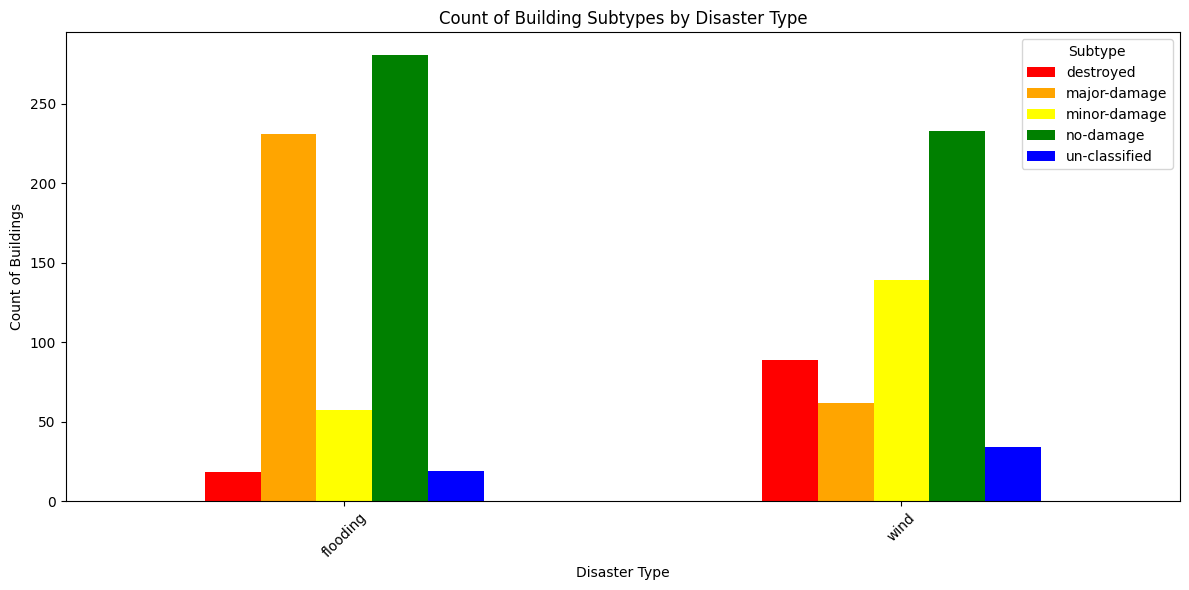

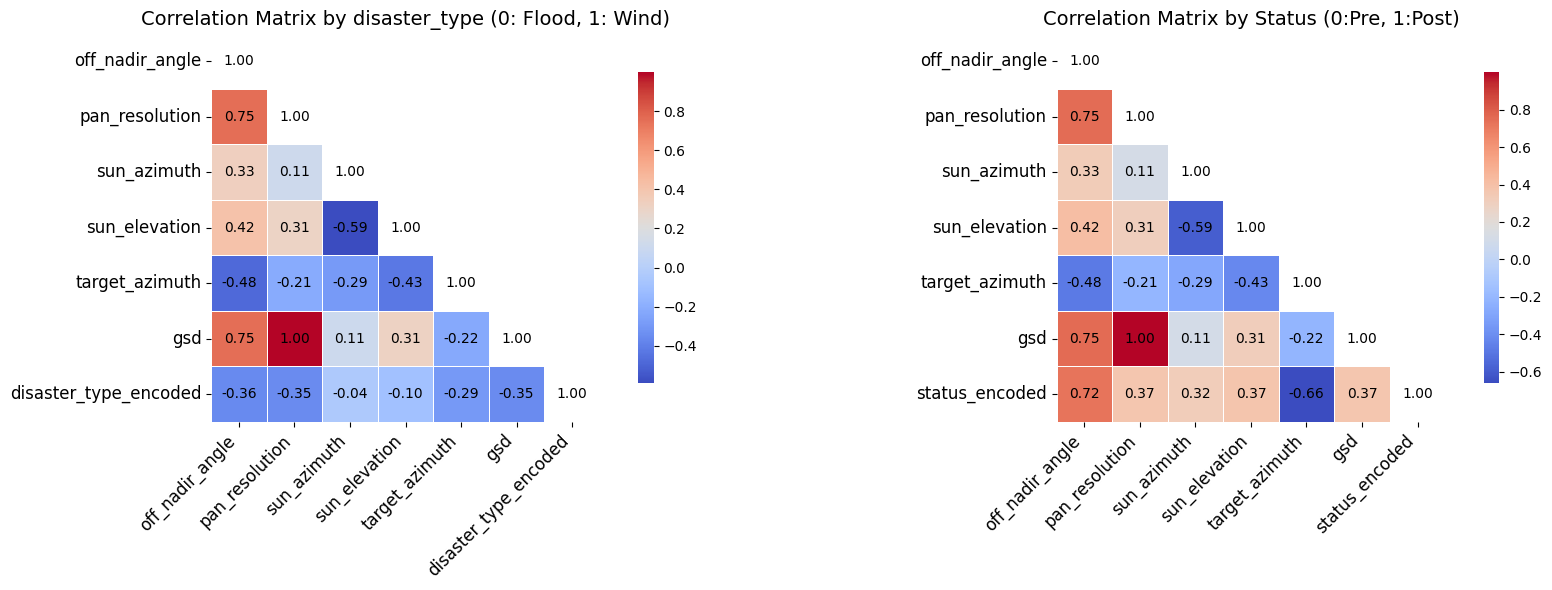

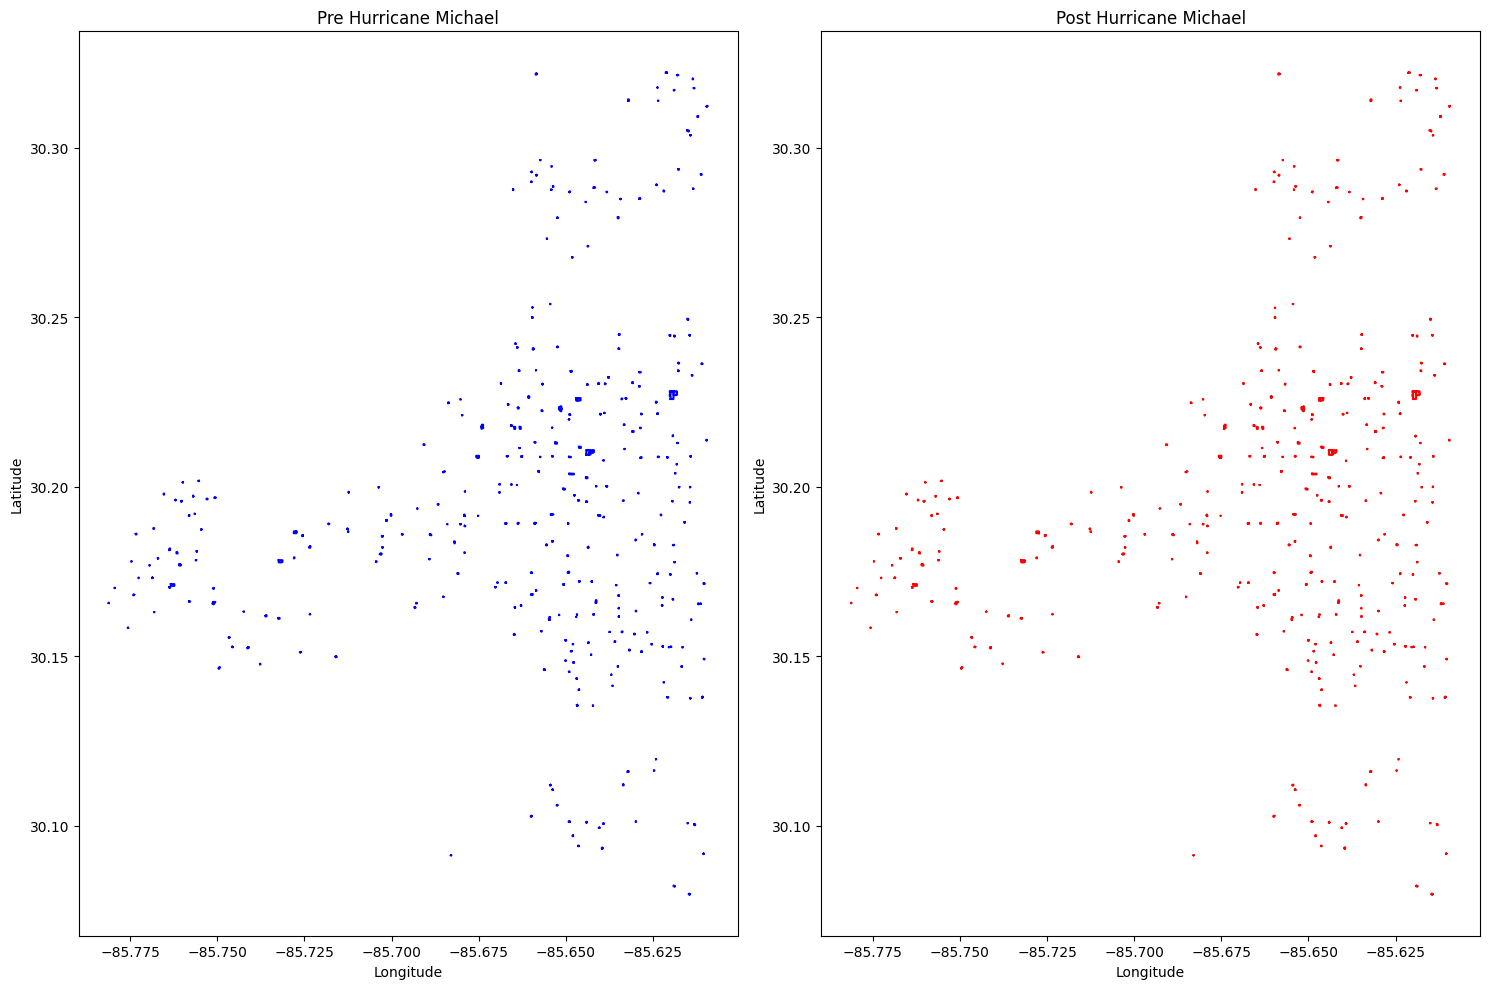

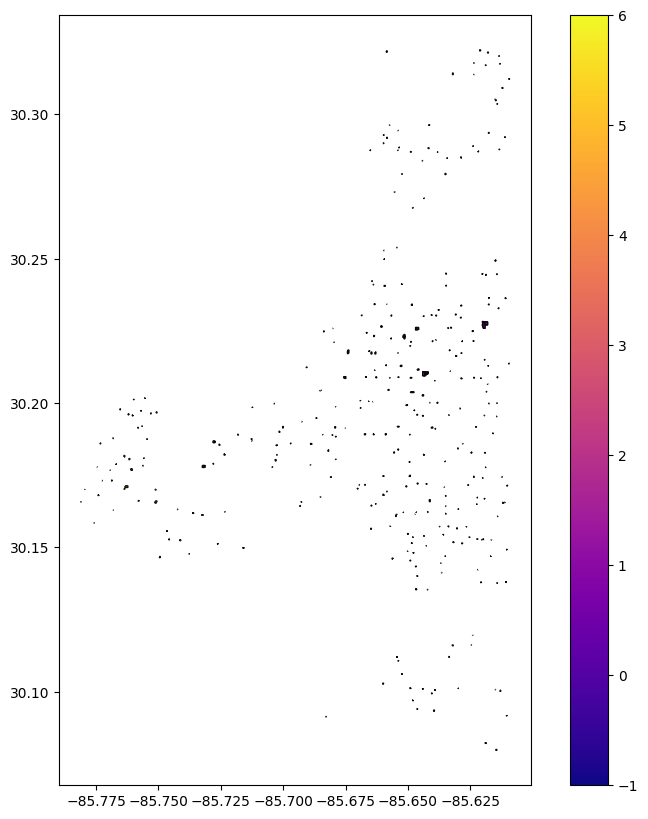

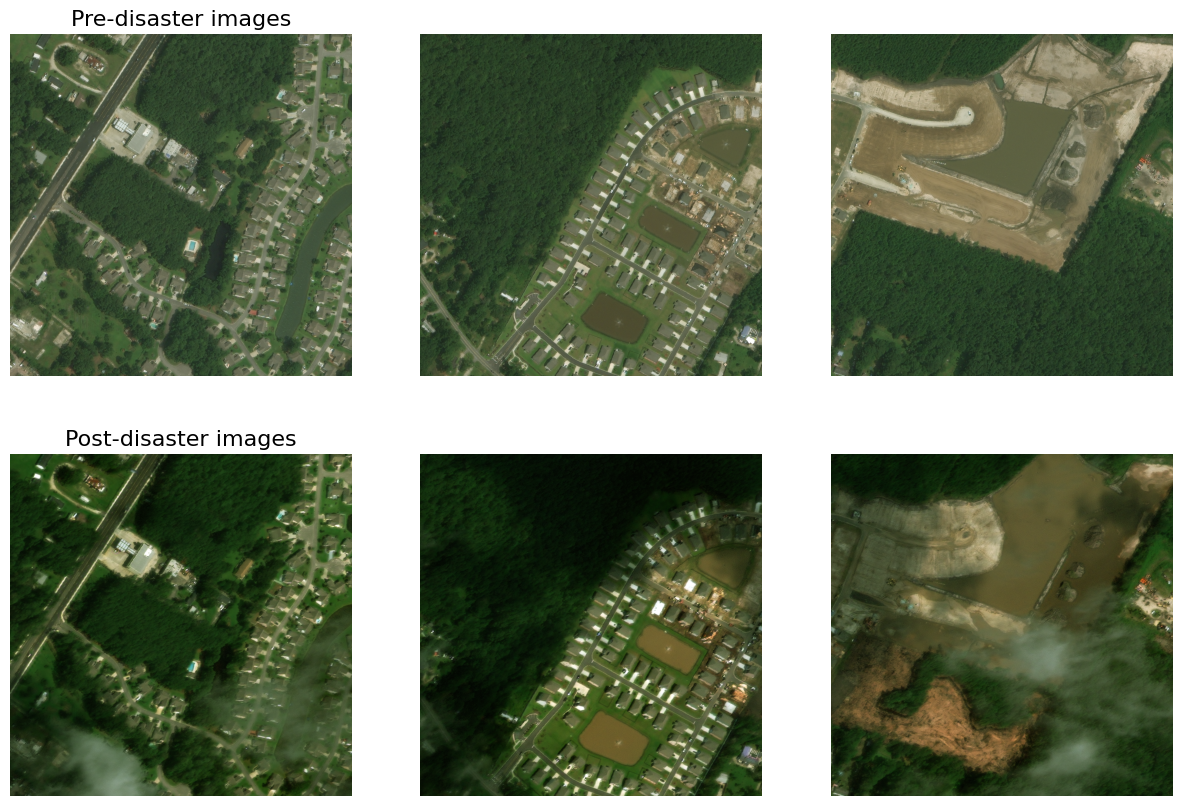

In [11]:
%run "DataExploration.ipynb";

## Data Preprocessing

In [7]:
pre_resized_img, pre_mask_resized_img, polygon_data= preprocess_data(hurricane_pre_df, hurricane_post_df, images_dir);

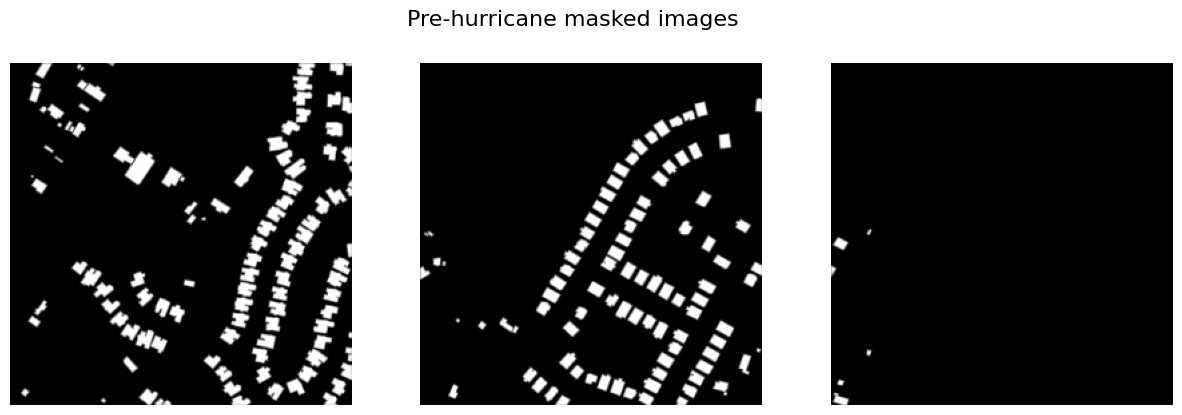

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

# Display pre-disaster images 
for i in range(3) :
    axes[i].imshow(pre_resized_img[i])
    axes[i].axis('off')

fig.suptitle("Pre-hurricane masked images", fontsize=16)
fig.subplots_adjust(top=1.4)
plt.show()

## Data Preparation for Damage Classification

In [9]:
#For Classification model
data_df = pd.DataFrame(polygon_data)
data_df.head()
final_df = data_df.drop(['polygon_points'], axis=1)
# Renaming columns
final_df = final_df.rename(columns={'uid': 'building_uid',
                                    'damage_type': 'labels'})
# Convert labels to strings
final_df['labels'] = final_df['labels'].astype(str)
final_df.head()

,building_uid,labels
0,82799c02-ee88-452a-a615-7df5e64560e8.png,0
1,bbc71c55-2b37-4582-842e-27a70431dd56.png,0
2,243c58e3-d7f9-4feb-a879-11ef7fc64a75.png,0
3,aa1a6143-efc6-4d66-b5d6-2e827573f694.png,0
4,2b9f0812-faa6-4635-a6a2-1b214c273a7f.png,0


### Class Imbalance 

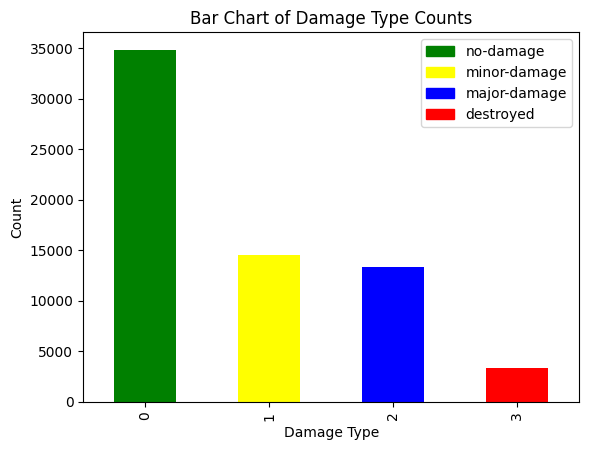

In [10]:
color_set = ['green', 'yellow', 'blue', 'red']
label_names = ['no-damage', 'minor-damage', 'major-damage', 'destroyed']

# Bar plot of damage type
final_df['labels'].value_counts().plot(kind='bar', color=color_set)
plt.xlabel('Damage Type')
plt.ylabel('Count')
plt.title('Bar Chart of Damage Type Counts')
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in color_set], 
           labels=label_names)
plt.show()

From the plot above, we observe a class imbalance, with class 0 ('no-damage') being the majority class and class 3 the minority class. To address this imbalance, we randomly selected 17,000 samples from the 'no-damage' class (class 0) to align its size with the other damage categories. 

In [11]:
df_sample_no_damage = final_df[final_df['labels'] == '0'].sample(n=17000)
df_sample_rest = final_df[final_df['labels'] != '0']
balanced_df =  pd.concat([df_sample_rest,df_sample_no_damage])

# After resampling
balanced_df['labels'].value_counts()

0    17000
1    14550
2    13330
3     3359
Name: labels, dtype: int64

### Preparing data for stage 1 ResNet-50 model training

In [12]:
# Data set for stage 1 ResNet-50 model training
final_df_stage1 = final_df.copy()

final_df_stage1['labels'] = final_df_stage1['labels'].replace({
    '1': '1',
    '2': '1',
    '3': '1'
})

final_df_stage1['labels'].value_counts()

0    34846
1    31239
Name: labels, dtype: int64

In [13]:
print(final_df_stage1.shape)
print(balanced_df.shape)

(66085, 2)
(48239, 2)


## Data Splitting 

### Building Localization

In [14]:
X_train, X_valid, y_train, y_valid = split_data(pre_resized_img, pre_mask_resized_img);


(1219, 256, 256, 3)
(1219, 256, 256, 1)


### Damage Classification

In [15]:
train_df, valid_df, test_df = classification_split_data(balanced_df)

# Stage 1 data split
#train_df_stage1, valid_df_stage1 = classification_split_data(final_df_stage1)

train_generator, val_generator, test_generator = data_gen(train_df, valid_df, test_df, target_size=(128, 128), batch_size=64, num_classes=4)

(33767, 2)
(7236, 2)
(7236, 2)
Found 33767 validated image filenames belonging to 4 classes.
Found 7236 validated image filenames belonging to 4 classes.
Found 7236 validated image filenames belonging to 4 classes.


## Model Training

The following code block is designed to train multiple models if and only if training is explicitly required. Training these models is computationally expensive and generates large model files that cannot be uploaded due to size limitations. 

In [19]:
# # Uncomment the below only if training is required

# train_FCN_model();
# train_unet_model();
# train_CNN_model(train_generator, val_generator);
# train_MobileNet_model(train_generator, val_generator);
# train_ResNet50_model(train_generator, val_generator, num_classes=2, batch_size=64);
# train_ResNet50_model_stage2(train_generator, val_generator, num_classes=4, batch_size=64);

## Loading models and making predictions

### Building Localization Models

### FCN Model

In [61]:
with tf.device('/cpu:0'):
    fcn_model = tf.keras.models.load_model('model/FCN/FCN_model.keras')
    fcn_model.summary()
    
    # Making predictions
    fcn_pred = fcn_model.predict(X_valid)
    # Model Evaluation
    loss, accuracy = fcn_model.evaluate(X_valid, y_valid)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_31 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_32 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_34 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 256, 256, 64)     73792     
 ranspose)                                                       
                                                           

### U-Net Model

In [16]:
with tf.device('/cpu:0'):
    unet_model = tf.keras.models.load_model('model/Unet/Unet_model.keras')
    unet_model.summary()

    # Making predictions
    unet_pred = unet_model.predict(X_valid)
    
    # Model Evaluation
    loss, accuracy = unet_model.evaluate(X_valid, y_valid)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 256, 256, 64  256        ['conv2d_6[0][0]']               
 rmalization)                   )                                                             

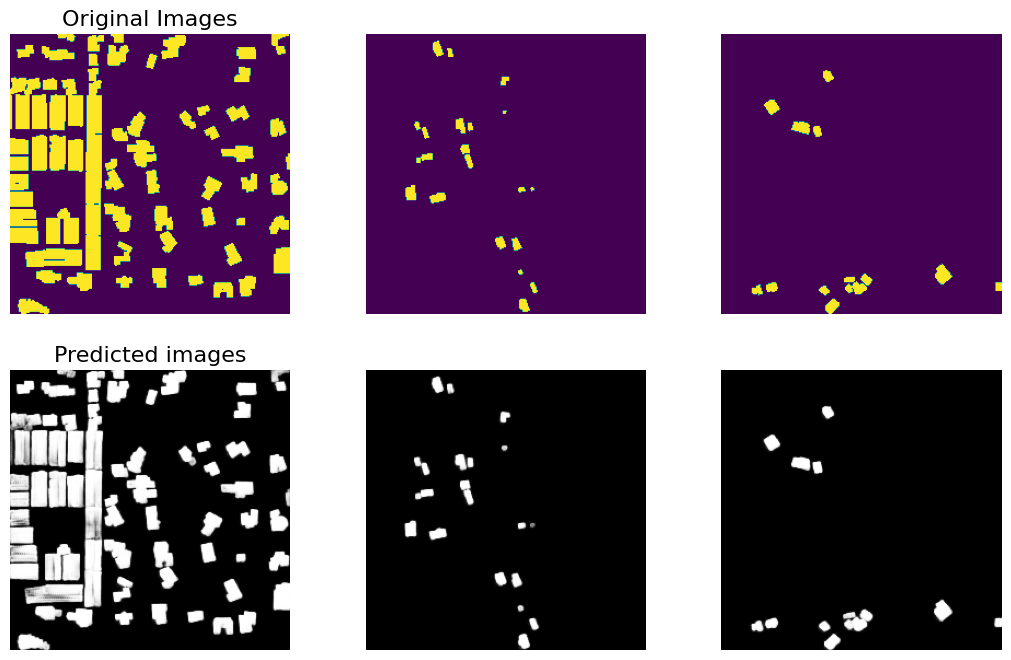

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))

# Display original images
for i in range(3) :
    axes[0, i].imshow(y_valid[i])
    axes[0, i].axis('off')

# Display predicted images
for i in range(3) :
    axes[1, i].imshow(unet_pred[i], cmap='gray')
    axes[1, i].axis('off')

axes[0,0].set_title("Original Images", fontsize=16)
axes[1,0].set_title("Predicted images", fontsize=16)
plt.show()

## Damage Classification Models

### Simple CNN 

In [35]:
with tf.device('/cpu:0'):
    CNN_model = tf.keras.models.load_model('model/simpleCNN/simpleCNN_model.keras')
    CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                      

In [36]:
# Making predictions
CNN_predictions = CNN_model.predict(test_generator, verbose=1)
CNN_predicted_classes = np.argmax(CNN_predictions, axis=1)

true_labels = test_generator.classes

114/114 [==============================] - 67s 519ms/step


In [37]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, CNN_predicted_classes)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(true_labels, CNN_predicted_classes, target_names=label_names))

Accuracy: 0.58
Classification Report:
              precision    recall  f1-score   support

   no-damage       0.72      0.68      0.70      2530
minor-damage       0.53      0.39      0.45      2185
major-damage       0.51      0.83      0.63      2005
   destroyed       0.00      0.00      0.00       516

    accuracy                           0.58      7236
   macro avg       0.44      0.47      0.44      7236
weighted avg       0.55      0.58      0.55      7236



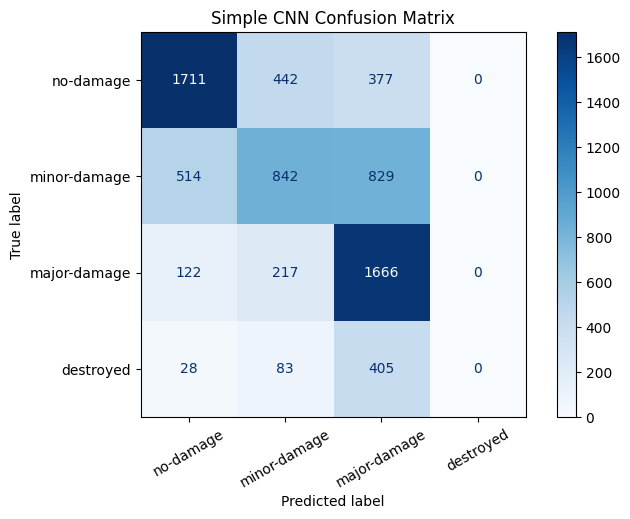

In [38]:
# Confusion Matrix
CNN_cm = confusion_matrix(true_labels, CNN_predicted_classes)

# Plot the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 5))
CNN_cm_disp = ConfusionMatrixDisplay(confusion_matrix=CNN_cm, display_labels=label_names)
CNN_cm_disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xticklabels(label_names, rotation=30)
plt.title('Simple CNN Confusion Matrix')
plt.show()

### MobileNet 

In [39]:
with tf.device('/cpu:0'):
    mobilenet_model = tf.keras.models.load_model('model/MobileNet/MobileNet_model.keras')
    mobilenet_model.summary()

Model: "MobileNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [40]:
# Making predictions
mobilenet_predictions = mobilenet_model.predict(test_generator, verbose=1)
mobilenet_predicted_classes = np.argmax(mobilenet_predictions, axis=1)

true_labels = test_generator.classes

114/114 [==============================] - 10s 77ms/step


In [41]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, mobilenet_predicted_classes)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(true_labels, mobilenet_predicted_classes, target_names=label_names))

Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

   no-damage       0.78      0.76      0.77      2530
minor-damage       0.62      0.62      0.62      2185
major-damage       0.70      0.75      0.73      2005
   destroyed       0.67      0.55      0.60       516

    accuracy                           0.70      7236
   macro avg       0.69      0.67      0.68      7236
weighted avg       0.70      0.70      0.70      7236



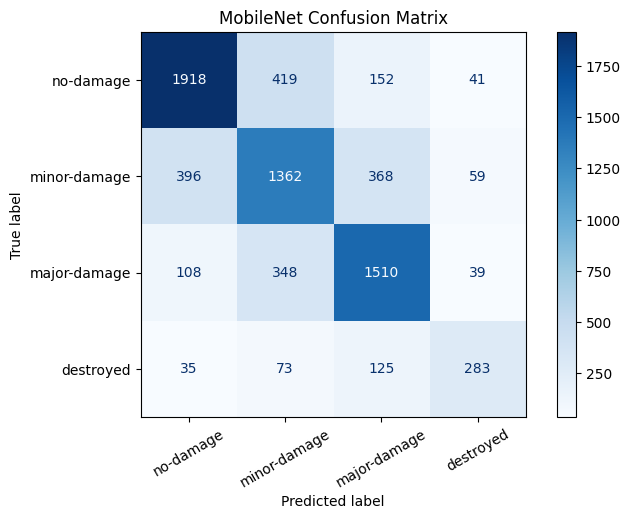

In [43]:
# Confusion Matrix
mobilenet_cm = confusion_matrix(true_labels, mobilenet_predicted_classes)

# Plot the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 5))
mobilenet_cm_disp = ConfusionMatrixDisplay(confusion_matrix=mobilenet_cm, display_labels=label_names)
mobilenet_cm_disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xticklabels(label_names, rotation=30)
plt.title('MobileNet Confusion Matrix')
plt.show()

### ResNet-50 

In [44]:
with tf.device('/cpu:0'):
    resnet50_model_stage2 = tf.keras.models.load_model('model/Resnet50/Resnet50_model_stage2.keras')
    resnet50_model_stage2.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [45]:
# Making predictions
resnet50_predictions = resnet50_model_stage2.predict(test_generator, verbose=1)
resnet50_predicted_classes = np.argmax(resnet50_predictions, axis=1)

true_labels = test_generator.classes

114/114 [==============================] - 20s 157ms/step


In [46]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, resnet50_predicted_classes)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(true_labels, resnet50_predicted_classes, target_names=label_names))

Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

   no-damage       0.78      0.70      0.73      2530
minor-damage       0.58      0.61      0.60      2185
major-damage       0.69      0.72      0.70      2005
   destroyed       0.54      0.57      0.55       516

    accuracy                           0.67      7236
   macro avg       0.65      0.65      0.65      7236
weighted avg       0.68      0.67      0.67      7236



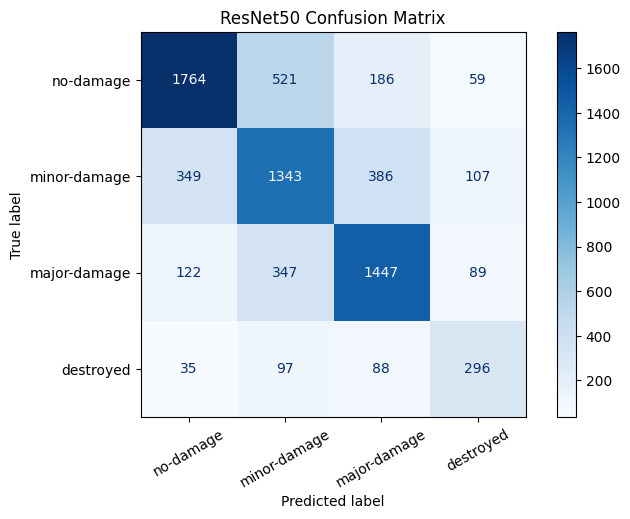

In [47]:
# Confusion Matrix
resnet50_cm = confusion_matrix(true_labels, resnet50_predicted_classes)

# Plot the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 5))
resnet50_cm_disp = ConfusionMatrixDisplay(confusion_matrix=resnet50_cm, display_labels=label_names)
resnet50_cm_disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xticklabels(label_names, rotation=30)
plt.title('ResNet50 Confusion Matrix')
plt.show()

## Model Result and Performance

### Building Localization

#### Tabular Result

In [48]:
# Metrics Calculation Definition
def calculate_metrics(y_true, y_pred, y_pred_raw):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred)
    pixel_accuracy = np.mean(y_true == y_pred)  # Ratio of correct pixels to total pixels
      
    # Mean Squared Error calculation
    mse = mean_squared_error(y_true, y_pred_raw.flatten())

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "IoU": iou,
        "Pixel Accuracy": pixel_accuracy,
        "MSE": mse,
        "Confusion Matrix": {
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn
        }
    }


In [49]:
# Calculate Robustness Loss and Accuracy
data_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
augmented_data = data_gen.flow(X_valid, y_valid, batch_size=32)

In [51]:
# Threshold predictions
fcn_pred_binary = (fcn_pred > 0.5).astype(np.uint8)
unet_pred_binary = (unet_pred > 0.5).astype(np.uint8)

# Flatten arrays 
y_valid_flat = y_valid.flatten()
fcn_pred_flat = fcn_pred_binary.flatten()
unet_pred_flat = unet_pred_binary.flatten()

# Calculate metrics for FCN and U-Net
fcn_metrics = calculate_metrics(y_valid_flat, fcn_pred_flat, fcn_pred)
unet_metrics = calculate_metrics(y_valid_flat, unet_pred_flat, unet_pred)

In [52]:
with tf.device('/cpu:0'):
    loss, accuracy = fcn_model.evaluate(augmented_data)
    print(f"Robustness Evaluation (FCN): Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
    
    unet_loss_noisy, unet_accuracy_noisy = unet_model.evaluate(augmented_data)
    print(f"\nU-Net Robustness - Loss on Noisy Data: {unet_loss_noisy:.4f}, Accuracy on Noisy Data: {unet_accuracy_noisy:.4f}")


8/8 [==============================] - 19s 2s/step - loss: 0.8048 - accuracy: 0.8785
Robustness Evaluation (FCN): Loss = 0.8048, Accuracy = 0.8785
8/8 [==============================] - 95s 12s/step - loss: 0.7074 - accuracy: 0.8786

U-Net Robustness - Loss on Noisy Data: 0.7074, Accuracy on Noisy Data: 0.8786


In [53]:
# Tabulation metrics
metrics_data = {
    "Model": ["FCN", "U-Net"],
    "Precision": [fcn_metrics['Precision'], unet_metrics['Precision']],
    "Recall": [fcn_metrics['Recall'], unet_metrics['Recall']],
    "F1-Score": [fcn_metrics['F1-Score'], unet_metrics['F1-Score']],
    "IoU": [fcn_metrics['IoU'], unet_metrics['IoU']],
    "MSE": [fcn_metrics['MSE'], unet_metrics['MSE']],
    "Pixel Accuracy": [fcn_metrics['Pixel Accuracy'], unet_metrics['Pixel Accuracy']],
    "True Positives (TP)": [fcn_metrics['Confusion Matrix']['TP'], unet_metrics['Confusion Matrix']['TP']],
    "False Positives (FP)": [fcn_metrics['Confusion Matrix']['FP'], unet_metrics['Confusion Matrix']['FP']],
    "False Negatives (FN)": [fcn_metrics['Confusion Matrix']['FN'], unet_metrics['Confusion Matrix']['FN']],
    "True Negatives (TN)": [fcn_metrics['Confusion Matrix']['TN'], unet_metrics['Confusion Matrix']['TN']],
    "Robustness Loss": [loss, unet_loss_noisy],
    "Robustness Accuracy": [accuracy, unet_accuracy_noisy]
}

# Creating the DataFrame
fcn_UNet_metrics_df = pd.DataFrame(metrics_data)
fcn_UNet_metrics_df = pd.DataFrame(metrics_data).round(4)

fcn_UNet_metrics_df

,Model,Precision,Recall,F1-Score,IoU,MSE,Pixel Accuracy,True Positives (TP),False Positives (FP),False Negatives (FN),True Negatives (TN),Robustness Loss,Robustness Accuracy
0,FCN,0.9417,0.8862,0.9131,0.8401,0.0102,0.9846,1296976,80336,166557,14446915,0.8048,0.8785
1,U-Net,0.9122,0.9561,0.9336,0.8755,0.0094,0.9876,1399334,134716,64199,14392535,0.7074,0.8786


Above table provides a comprehensive result of building localization of FCN and U-Net models performance in semantic segmentation tasks. 
The Fully Convolutional Network (FCN) demonstrated strong overall performance, achieving a Precision of 0.94 and an F1-Score of 0.91, reflecting its ability to identify building regions accurately while maintaining a balance between precision and recall. Its Intersection over Union (IoU) of 0.84 and Pixel Accuracy of 0.98 indicate that the model is effective in localizing buildings but occasionally misses finer details, as shown by its higher False Negatives (FN) count.
The U-Net model excelled in precision delineation of object boundaries, achieving a higher Recall of 0.96 and an F1-Score of 0.93, which highlights its robustness in capturing subtle details and ensuring fewer missed building regions, as reflected by its lower False Negatives (FN) count. With an IoU of 0.88 and Pixel Accuracy of 0.99, U-Net provides superior segmentation performance, benefiting from its skip connections that preserve spatial details across encoder-decoder layers. This architecture also yielded a lower MSE (0.01), underscoring its precision in generating binary masks for localized building regions.
While both models are effective for semantic segmentation, U-Net truly outperformed FCN in recall, IoU, and pixel accuracy, making it more adept for tasks requiring precise boundary delineation. Yet, FCN's efficiency and high precision make it a valuable alternative in scenarios prioritizing computational simplicity.

#### Visualization Result

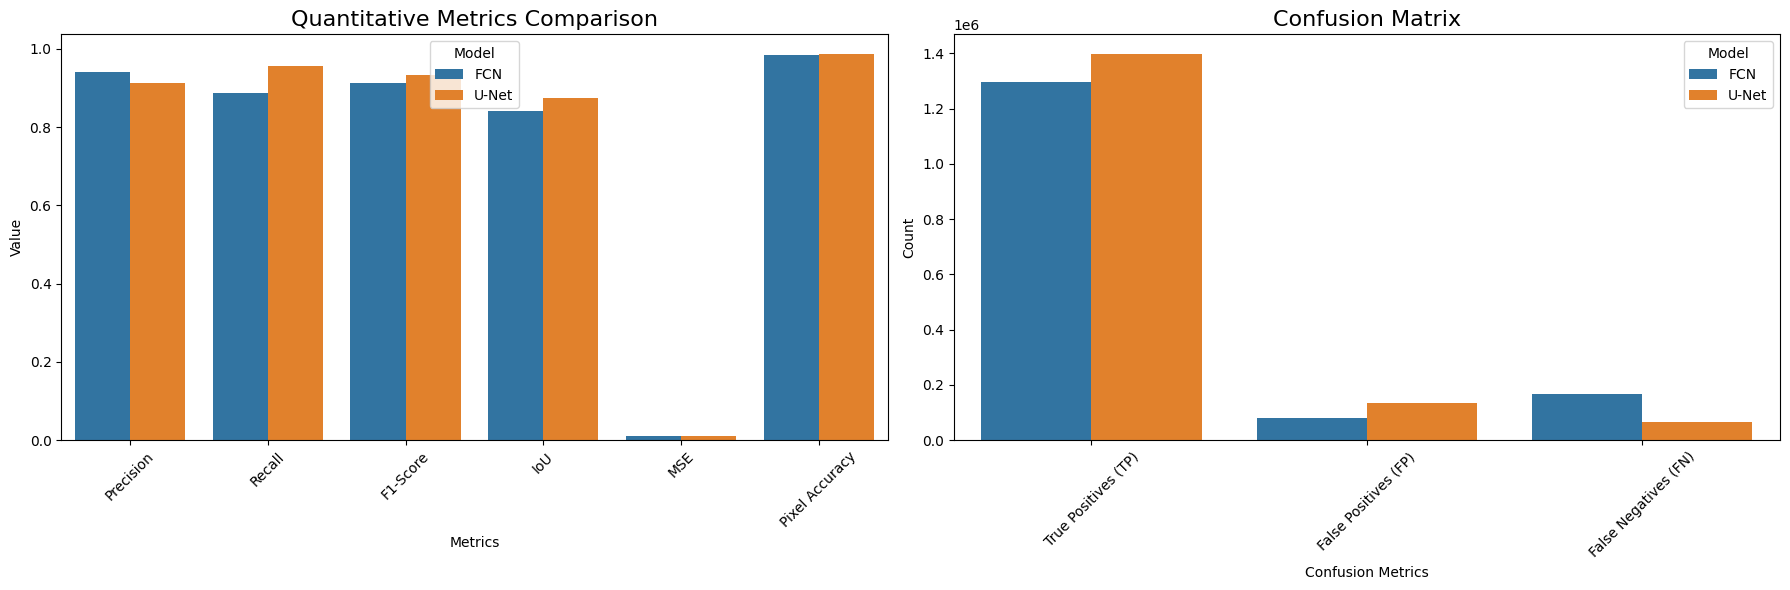

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Quantitative Metrics Bar Plot
def plot_metrics(df, metrics, title, ax):
    df_metrics = df.melt(id_vars="Model", value_vars=metrics, var_name="Metric", value_name="Value")
    
    sns.barplot(data=df_metrics, x="Metric", y="Value", hue="Model", ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel("Value")
    ax.set_xlabel("Metrics")
    ax.tick_params(axis='x', rotation=45)

quantitative_metrics = [
    "Precision", "Recall", "F1-Score", "IoU", "MSE", "Pixel Accuracy"
]

# Error Analysis Plot
def plot_error_analysis(df, metrics, title, ax):
    df_error = df.melt(id_vars="Model", value_vars=metrics, var_name="Confusion Matrix", value_name="Value")
    
    sns.barplot(data=df_error, x="Confusion Matrix", y="Value", hue="Model", ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel("Count")
    ax.set_xlabel("Confusion Metrics")
    ax.tick_params(axis='x', rotation=45)

error_metrics = [
    "True Positives (TP)", "False Positives (FP)", "False Negatives (FN)"
]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_metrics(fcn_UNet_metrics_df, quantitative_metrics, "Quantitative Metrics Comparison", axes[0])
plot_error_analysis(fcn_UNet_metrics_df, error_metrics, "Confusion Matrix", axes[1])

plt.tight_layout()
plt.show()

### Damage Classification

#### Tabular Result

In [55]:
def damage_class_calculate_metrics(y_true, y_pred, y_pred_raw, average='weighted'):
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    iou = jaccard_score(y_true, y_pred, average=average)
    pixel_accuracy = np.mean(y_true == y_pred)
    mse = mean_squared_error(y_true, y_pred_raw.argmax(axis=1))

    # calculate confusion matrix in diagonal elements
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    total_tp = tp.sum()
    total_fp = fp.sum()
    total_fn = fn.sum()
    total_tn = tn.sum()

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "IoU": iou,
        "Pixel Accuracy": pixel_accuracy,
        "MSE": mse,
        "Confusion Matrix": {
            "TP": total_tp,
            "FP": total_fp,
            "FN": total_fn,
            "TN": total_tn
        }
    }



In [56]:
simplecnn_metrics = damage_class_calculate_metrics(true_labels, CNN_predicted_classes, CNN_predictions, average='weighted')
mobilenet_metrics =  damage_class_calculate_metrics(true_labels, mobilenet_predicted_classes, mobilenet_predictions, average='weighted')
resnet_metrics = damage_class_calculate_metrics(true_labels, resnet50_predicted_classes, resnet50_predictions, average='weighted')

In [57]:
def robustness_loss(predictions, true_labels_one_hot):
    loss = np.abs(predictions - true_labels_one_hot).mean()
    return loss

def robustness_accuracy(predictions, true_labels_one_hot, threshold=0.1):
    robust = np.abs(predictions - true_labels_one_hot) < threshold
    return robust.sum() / true_labels_one_hot.size



In [58]:
true_labels_one_hot = to_categorical(true_labels, num_classes=CNN_predictions.shape[1])
simplecnn_robustness_loss = robustness_loss(CNN_predictions, true_labels_one_hot)
simplecnn_robustness_acc = robustness_accuracy(CNN_predictions, true_labels_one_hot)

mobilenet_robustness_loss = robustness_loss(mobilenet_predictions, true_labels_one_hot)
mobilenet_robustness_acc = robustness_accuracy(mobilenet_predictions, true_labels_one_hot)

resnet50_robustness_loss = robustness_loss(resnet50_predictions, true_labels_one_hot)
resnet50_robustness_acc = robustness_accuracy(resnet50_predictions, true_labels_one_hot)

In [59]:
damage_class_metrics_data = {
    "Model": ["SimpleCNN", "MobileNet", "ResNet50"],
    "Precision": [simplecnn_metrics['Precision'], mobilenet_metrics['Precision'], resnet_metrics['Precision']],
    "Recall": [simplecnn_metrics['Recall'], mobilenet_metrics['Recall'], resnet_metrics['Recall']],
    "F1-Score": [simplecnn_metrics['F1-Score'], mobilenet_metrics['F1-Score'], resnet_metrics['F1-Score']],
    "IoU": [simplecnn_metrics['IoU'], mobilenet_metrics['IoU'], resnet_metrics['IoU']],
    "Pixel Accuracy": [simplecnn_metrics['Pixel Accuracy'], mobilenet_metrics['Pixel Accuracy'], resnet_metrics['Pixel Accuracy']],
    "MSE": [simplecnn_metrics['MSE'], mobilenet_metrics['MSE'], resnet_metrics['MSE']],
    "True Positives (TP)": [simplecnn_metrics['Confusion Matrix']['TP'], mobilenet_metrics['Confusion Matrix']['TP'], resnet_metrics['Confusion Matrix']['TP']],
    "False Positives (FP)": [simplecnn_metrics['Confusion Matrix']['FP'], mobilenet_metrics['Confusion Matrix']['FP'], resnet_metrics['Confusion Matrix']['FP']],
    "False Negatives (FN)": [simplecnn_metrics['Confusion Matrix']['FN'], mobilenet_metrics['Confusion Matrix']['FN'], resnet_metrics['Confusion Matrix']['FN']],
    "True Negatives (TN)": [simplecnn_metrics['Confusion Matrix']['TN'], mobilenet_metrics['Confusion Matrix']['TN'], resnet_metrics['Confusion Matrix']['TN']],
    "Robustness Loss": [simplecnn_robustness_loss, mobilenet_robustness_loss, resnet50_robustness_loss],
    "Robustness Accuracy": [simplecnn_robustness_acc, mobilenet_robustness_acc, resnet50_robustness_acc]
}

damage_class_metrics_df = pd.DataFrame(damage_class_metrics_data).round(4)
damage_class_metrics_df


,Model,Precision,Recall,F1-Score,IoU,Pixel Accuracy,MSE,True Positives (TP),False Positives (FP),False Negatives (FN),True Negatives (TN),Robustness Loss,Robustness Accuracy
0,SimpleCNN,0.5533,0.5831,0.5536,0.4018,0.5831,0.6892,4219,3017,3017,18691,0.3010,0.2271
1,MobileNet,0.7017,0.7011,0.7006,0.5432,0.7011,0.5455,5073,2163,2163,19545,0.1950,0.5533
2,ResNet50,0.6760,0.6703,0.6721,0.5097,0.6703,0.6459,4850,2386,2386,19322,0.2265,0.4498


#### Visualization Result

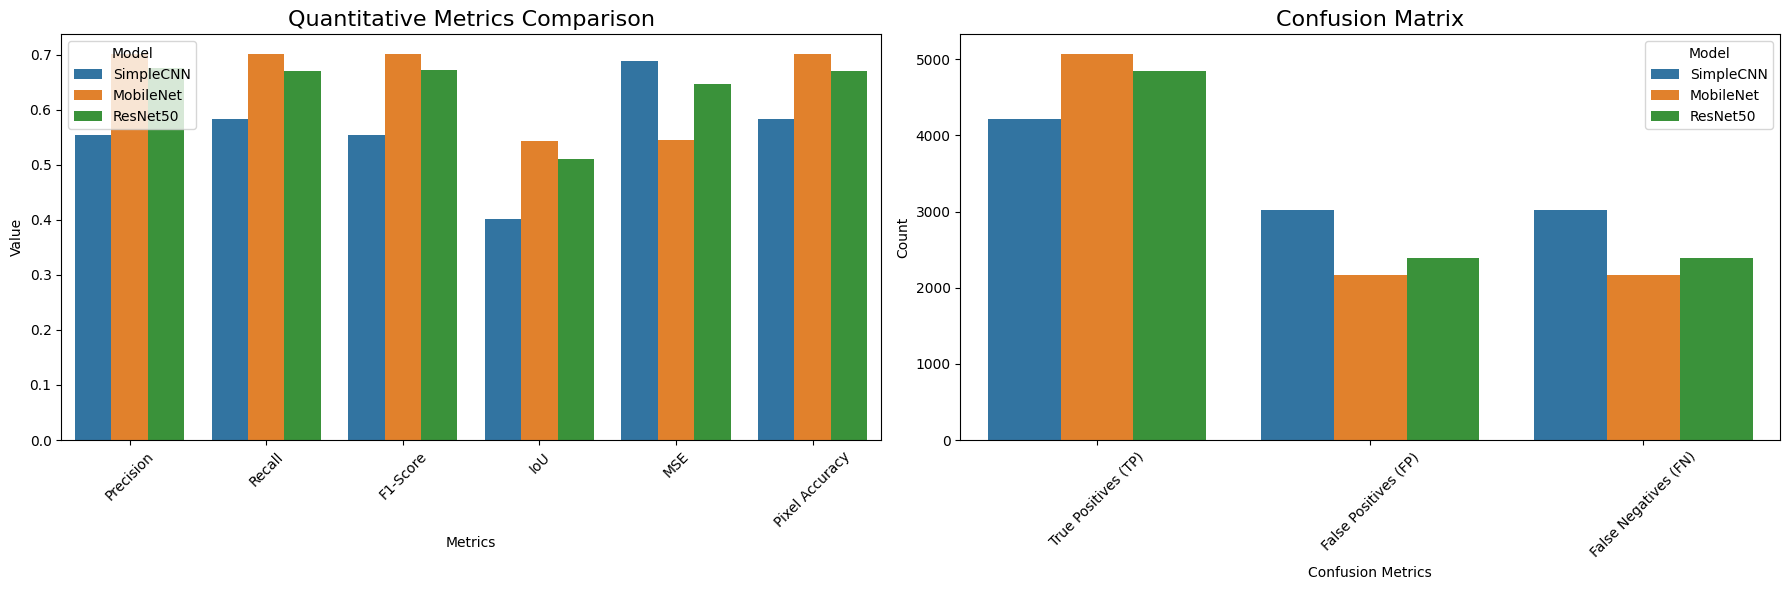

In [60]:
def plot_error_analysis(df, metrics, title, ax):
    # Flatten confusion matrix values
    df_error = pd.DataFrame({
        "Model": df["Model"],
        "True Positives (TP)": df["True Positives (TP)"],
        "False Positives (FP)": df["False Positives (FP)"],
        "False Negatives (FN)": df["False Negatives (FN)"],
        "True Negatives (TN)": df["True Negatives (TN)"]
    })
    
    df_error = df_error.melt(id_vars="Model", value_vars=metrics, var_name="Confusion Matrix", value_name="Value")
    
    sns.barplot(data=df_error, x="Confusion Matrix", y="Value", hue="Model", ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel("Count")
    ax.set_xlabel("Confusion Metrics")
    ax.tick_params(axis='x', rotation=45)

error_metrics = [
    "True Positives (TP)", "False Positives (FP)", "False Negatives (FN)"
]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_metrics(damage_class_metrics_df, quantitative_metrics, "Quantitative Metrics Comparison", axes[0])
plot_error_analysis(damage_class_metrics_df, error_metrics, "Confusion Matrix", axes[1])

plt.tight_layout()
plt.show()

The MobileNet model outperforms both SimpleCNN and ResNet50 across most metrics, achieving the highest precision (0.7041), recall (0.7034), and F1-score (0.7029), reflecting its strong ability to classify building damage accurately.  
It also achieves the highest Intersection over Union (IoU) of 0.5461, which measures the overlap between the predicted and actual regions of building damage. This indicates that MobileNet is particularly effective in accurately segmenting the damaged areas, capturing a significant portion of the true damage while minimizing false positives. Additionally, the model's pixel accuracy of 0.7034 reflects its ability to correctly classify a majority of pixels in the image, further underscoring its robust performance in both classification and segmentation tasks.
MobileNet's lower MSE (0.5325) and robustness loss (0.1944) demonstrate its efficiency and ability to generalize well in varying conditions. In comparison, SimpleCNN and ResNet50 show lower overall performance, especially in robustness and classification accuracy, therefore MobileNet proving to be the most effective model for the task.